In [3]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Magic command to change plotting backend
#%matplotlib qt

# Magic command to load watermark
#%load_ext watermark

In [4]:
# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [3]:
# Print versions
%watermark --author "Eduarda & Fernando" --date --time --python --machine --iversion --watermark 

UsageError: Line magic function `%watermark` not found.


In [5]:
# load data
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=400):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}/*_connectivity_matrix.npy')
    #matrix_files = glob.glob(f'{results_dir}/connectivity_matrices/*_connectivity_matrix.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels


# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
#os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 400 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=400)

# Now you can proceed with the visualization functions

Found 19 connectivity matrices


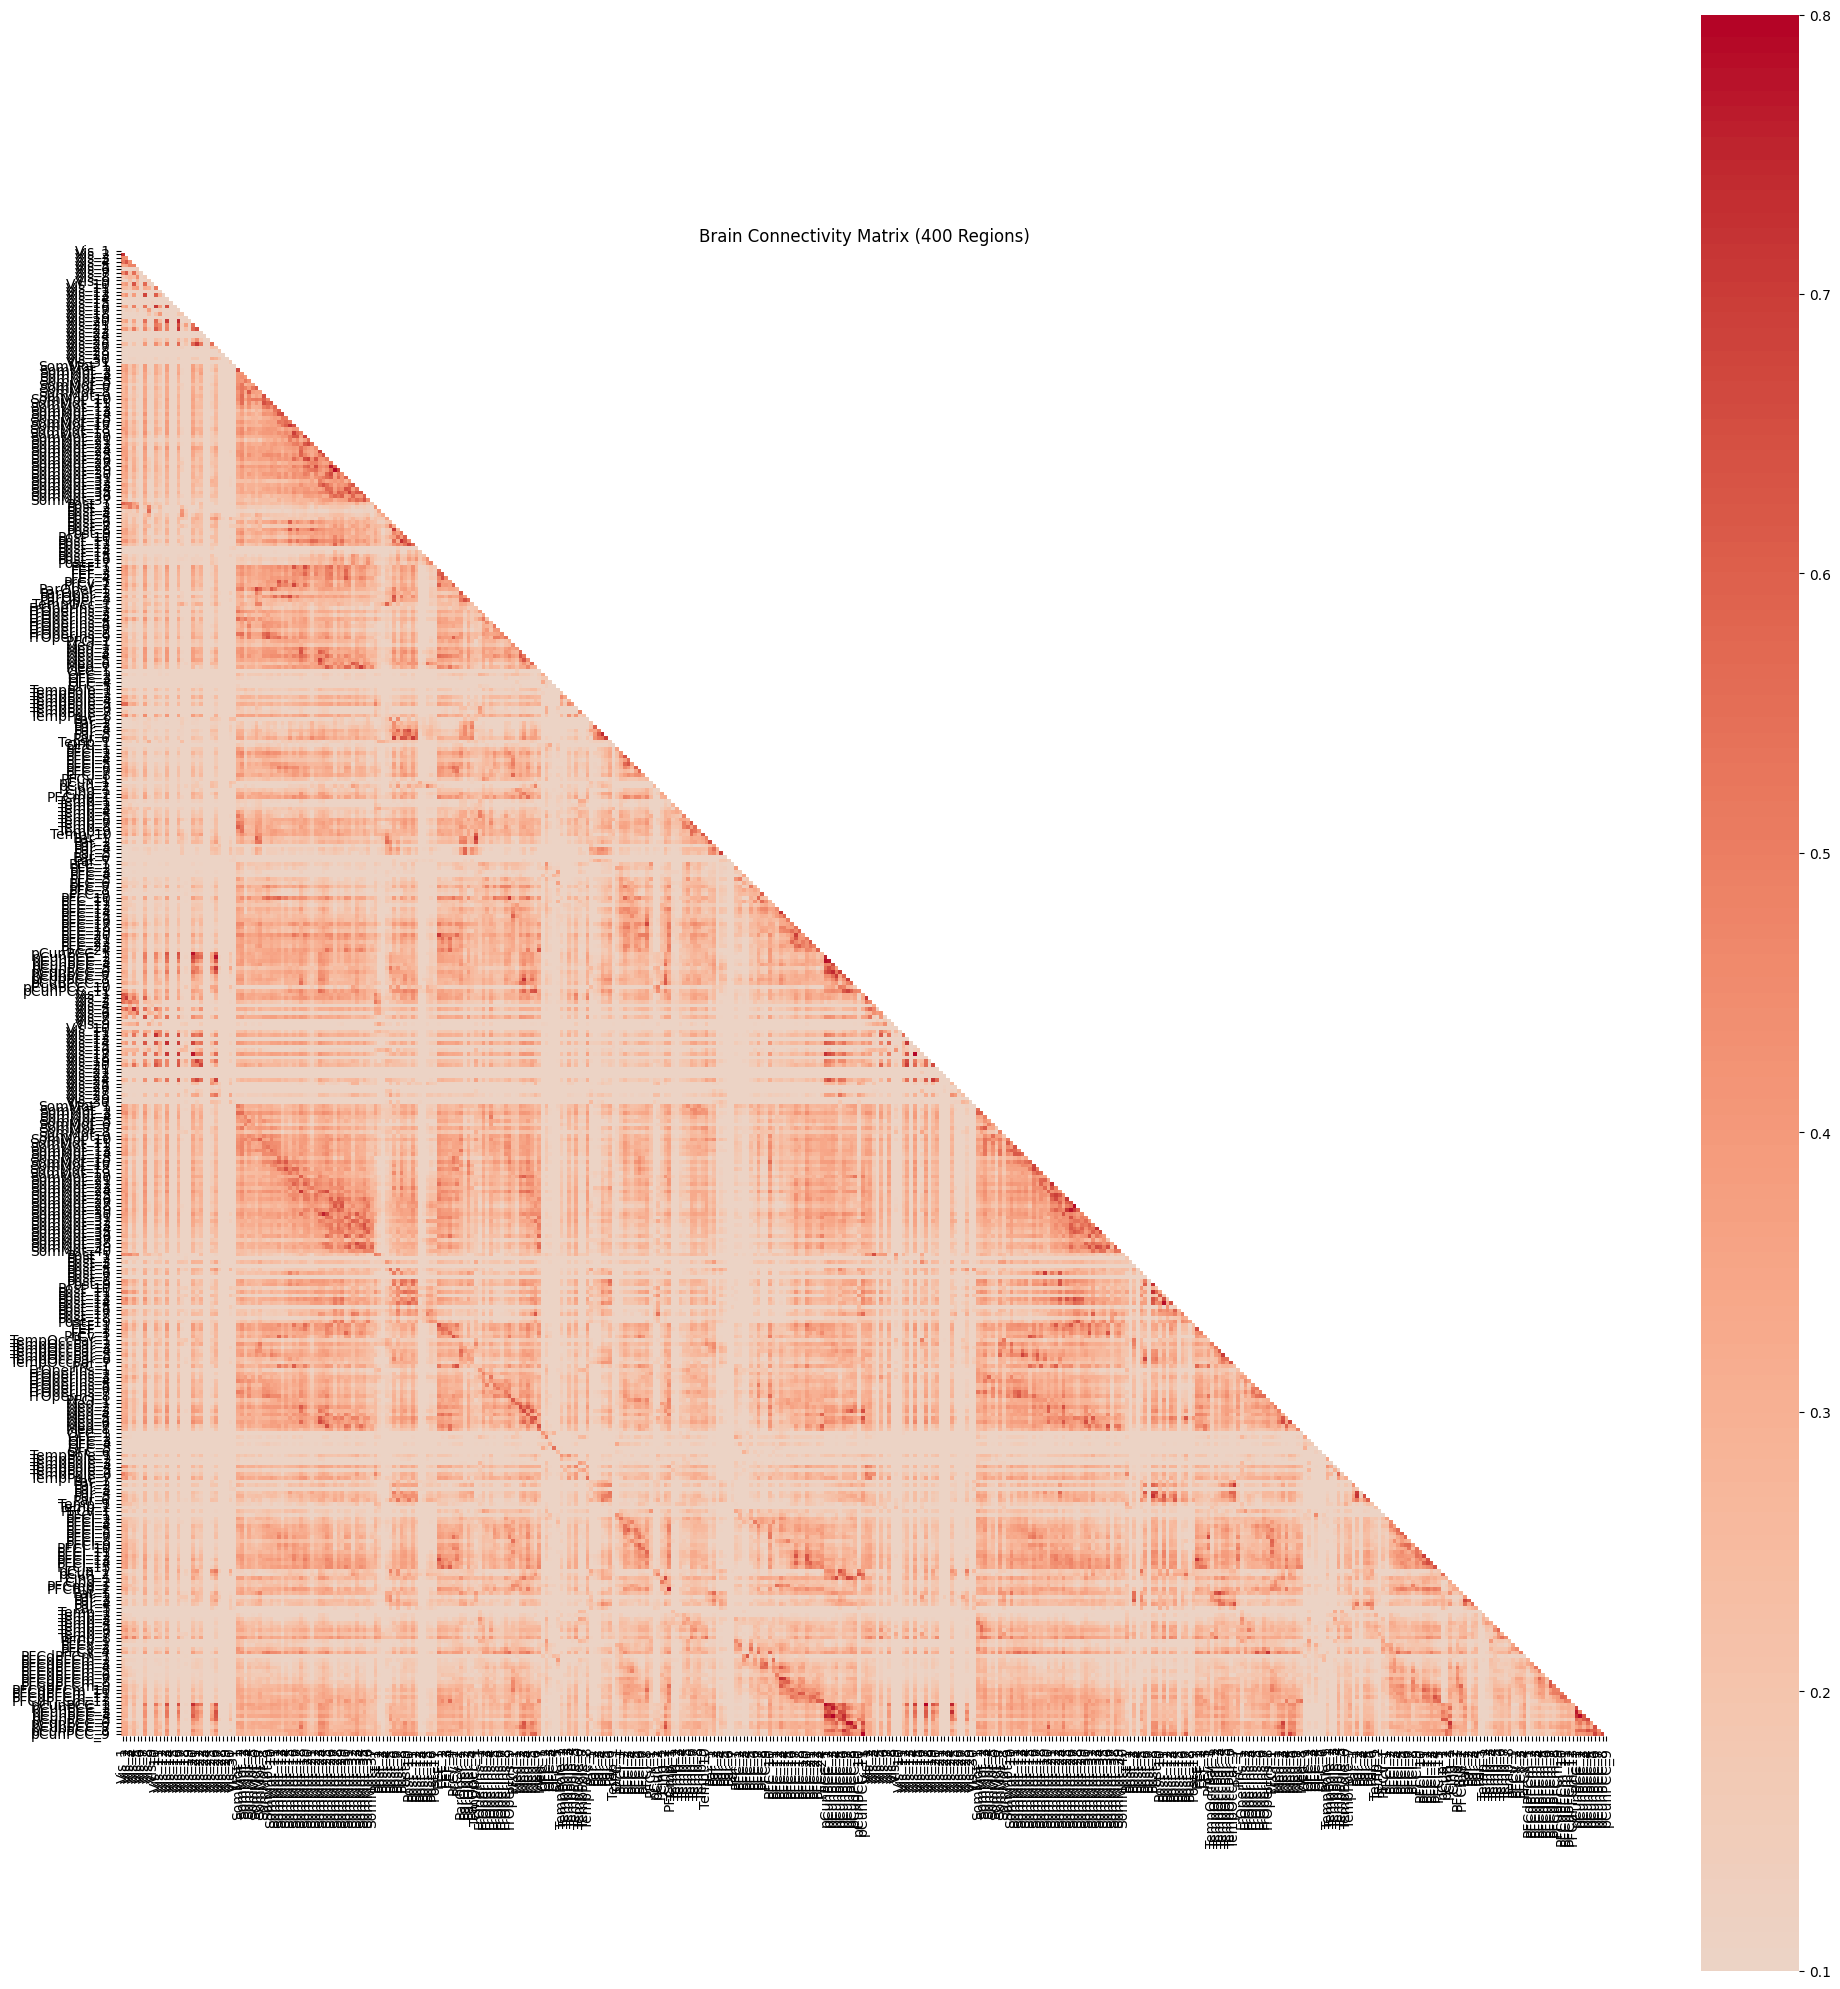

In [6]:
# heatmap
from nilearn import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get Schaefer atlas and labels
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2)
labels = schaefer_atlas.labels

# Clean up labels - remove the prefix and hemisphere info for clarity
clean_labels = [label.decode('utf-8').split('_')[-2] + '_' + label.decode('utf-8').split('_')[-1] 
               for label in labels]

# Create figure with square aspect ratio
plt.figure(figsize=(20, 20))

# Create mask for upper triangle
mask = np.zeros_like(matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Create the heatmap
sns.heatmap(matrix, 
            cmap='coolwarm',
            center=0,
            cbar=True,
            square=True,  # Force square shape
            mask=mask,
            vmin=0.1,
            vmax=0.8,
            xticklabels=clean_labels,
            yticklabels=clean_labels)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title('Brain Connectivity Matrix (400 Regions)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

Network after thresholding and removing self-loops:
Number of nodes: 400
Number of edges: 25

After removing isolated nodes:
Number of nodes remaining: 29
Number of edges: 25


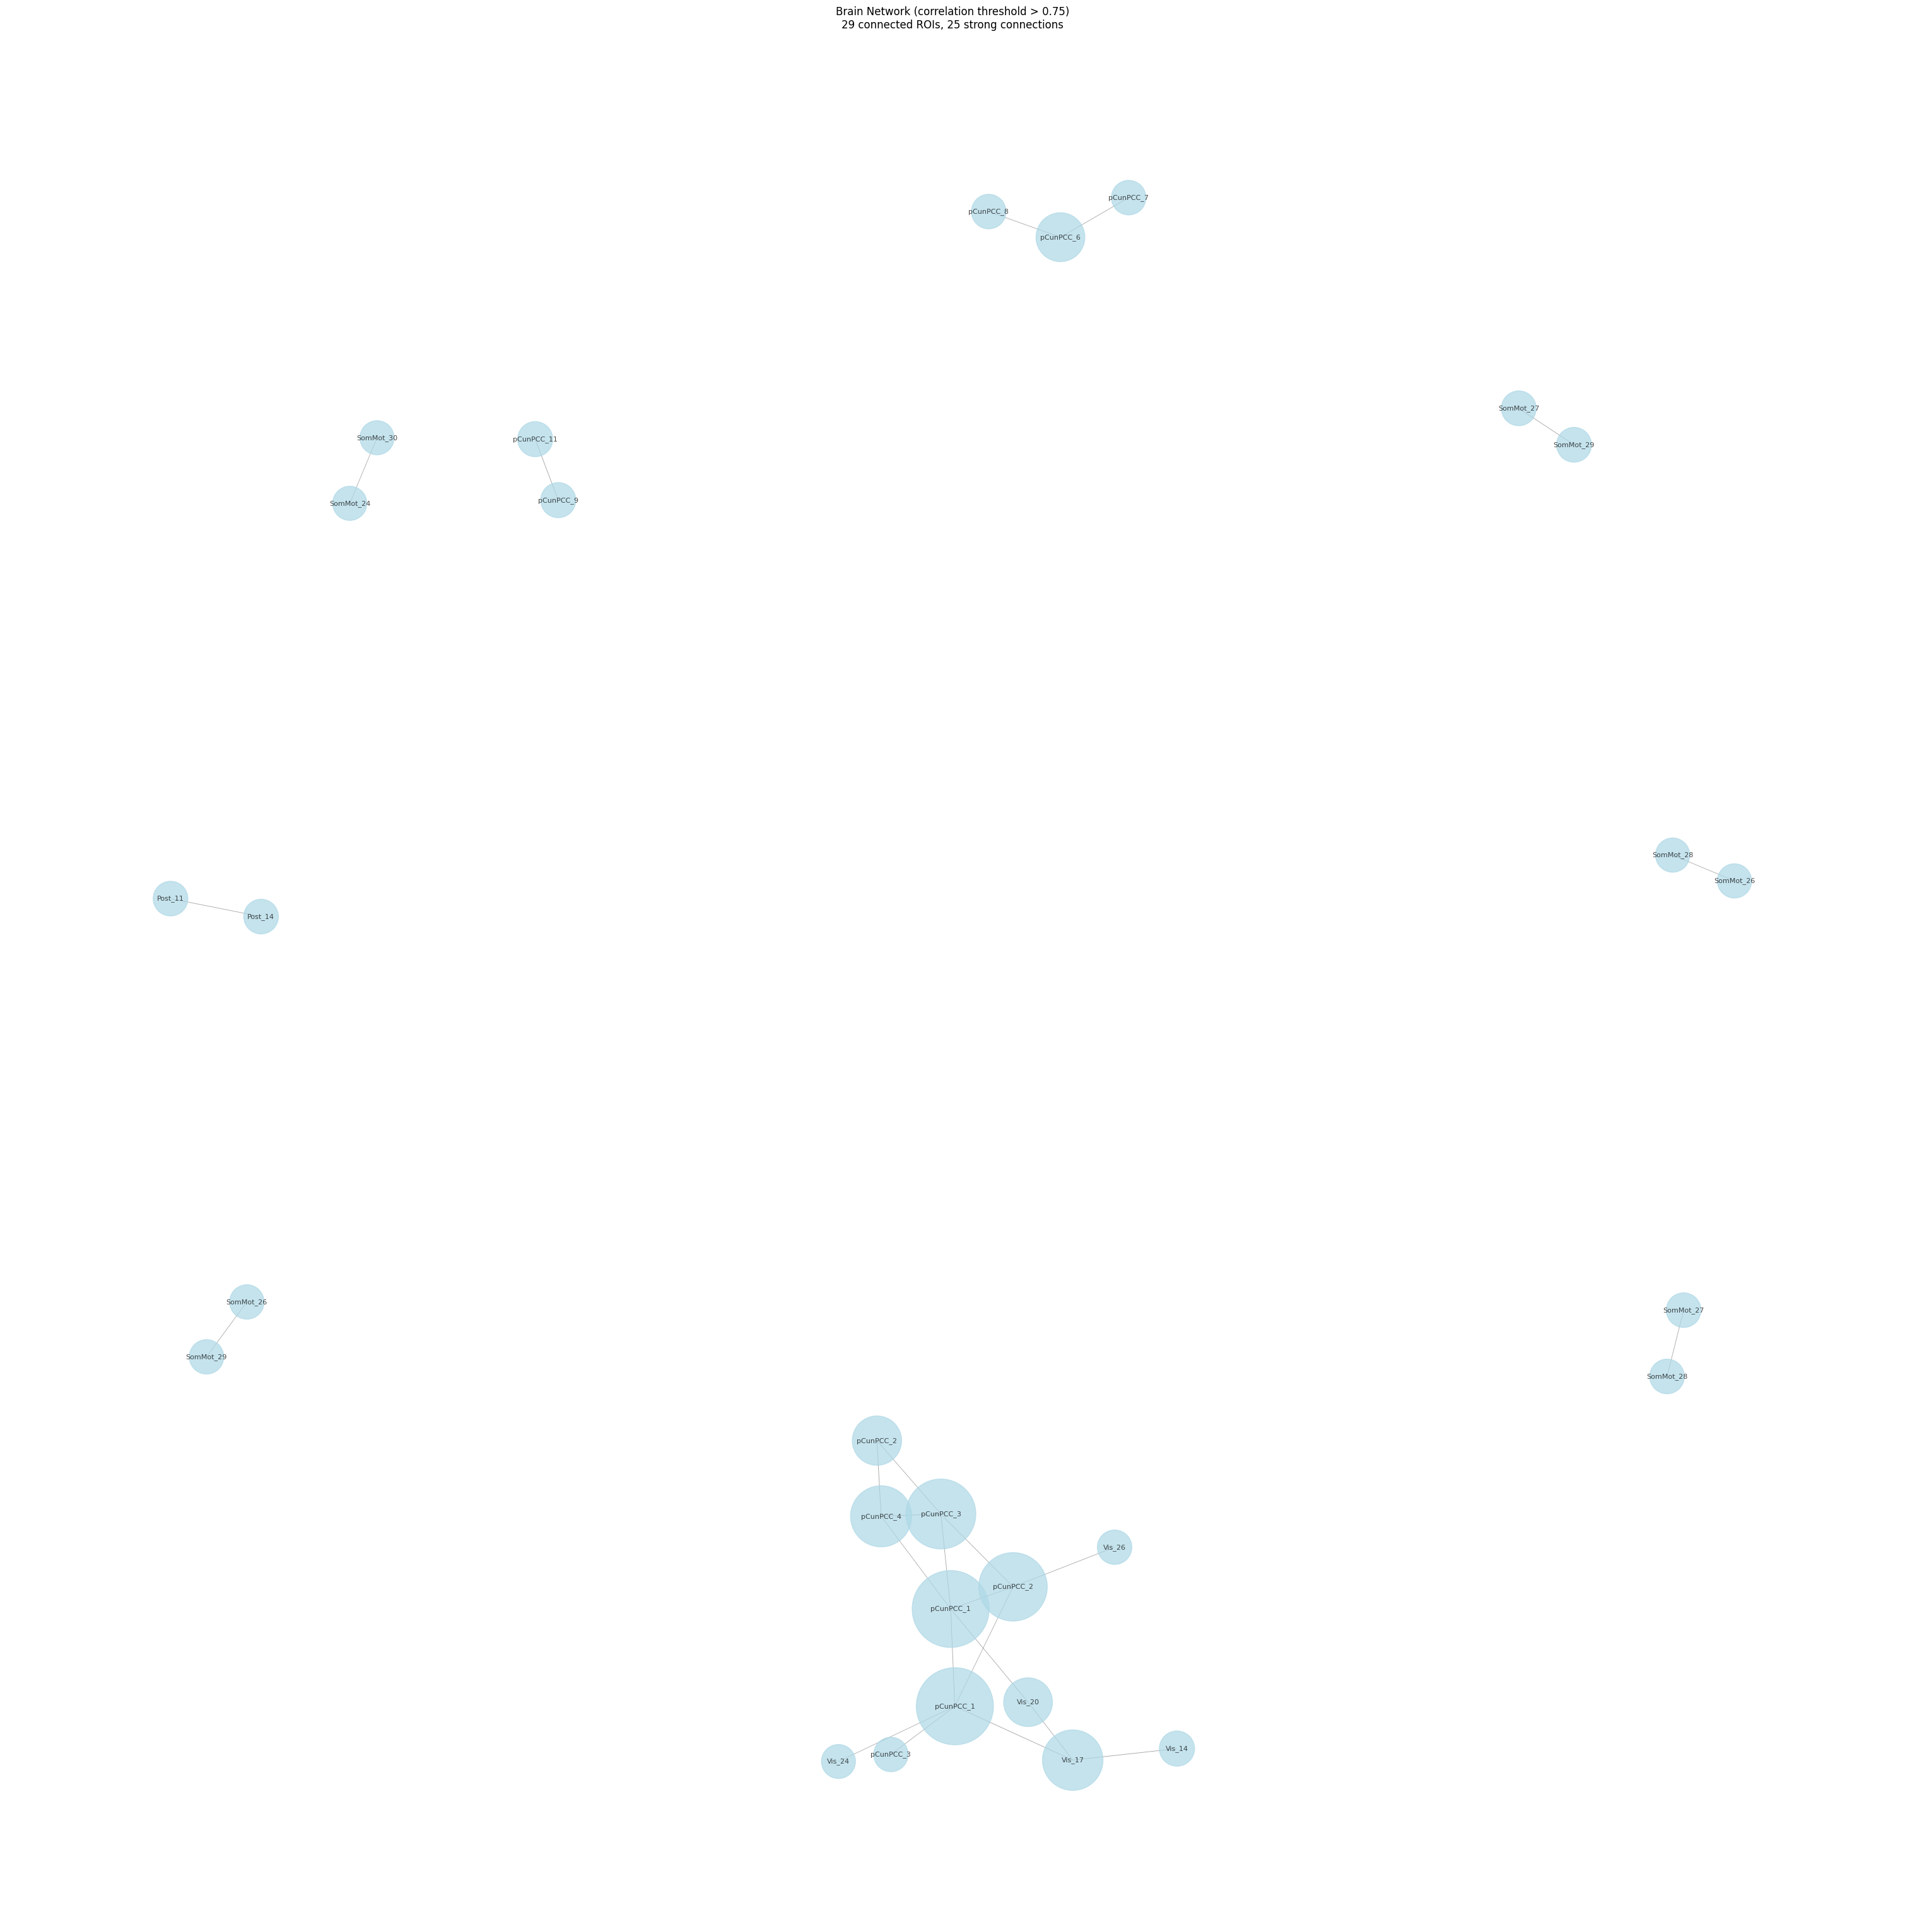

In [13]:
#graph theory analysis and visualization
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets

# Get Schaefer atlas and labels
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2)
labels = schaefer_atlas.labels

# Clean up labels - remove the prefix and hemisphere info for clarity
clean_labels = [label.decode('utf-8').split('_')[-2] + '_' + label.decode('utf-8').split('_')[-1] 
                for label in labels]

# First create the thresholded matrix
matrix_thresholded = matrix.copy()
threshold = 0.75
matrix_thresholded[matrix_thresholded <= threshold] = 0

# Create graph from thresholded matrix
G = nx.from_numpy_array(matrix_thresholded)

# Remove self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

print(f"Network after thresholding and removing self-loops:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Remove isolated nodes (nodes with no connections)
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

print(f"\nAfter removing isolated nodes:")
print(f"Number of nodes remaining: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Create label dictionary for remaining nodes
node_labels = {node: clean_labels[node] for node in G.nodes()}

# Calculate normalized node strengths
strength = G.degree(weight='weight')
node_sizes = [val * 2000 for (node, val) in strength]  # Scale for visibility

# Set up the visualization
plt.figure(figsize=(30, 30))

# Calculate edge widths
edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, k=2/np.sqrt(G.number_of_nodes()), iterations=100)

# Draw network
nx.draw(G, pos, 
        with_labels=True, 
        width=np.power(edgewidth, 2),  # Square the edge widths
        edge_color='grey', 
        node_size=node_sizes,
        labels=node_labels,
        font_color='black', 
        node_color='lightblue',  # Can be modified based on your needs
        alpha=0.7, 
        font_size=8)

plt.title(f'Brain Network (correlation threshold > {threshold})\n'
          f'{G.number_of_nodes()} connected ROIs, {G.number_of_edges()} strong connections')

plt.show()

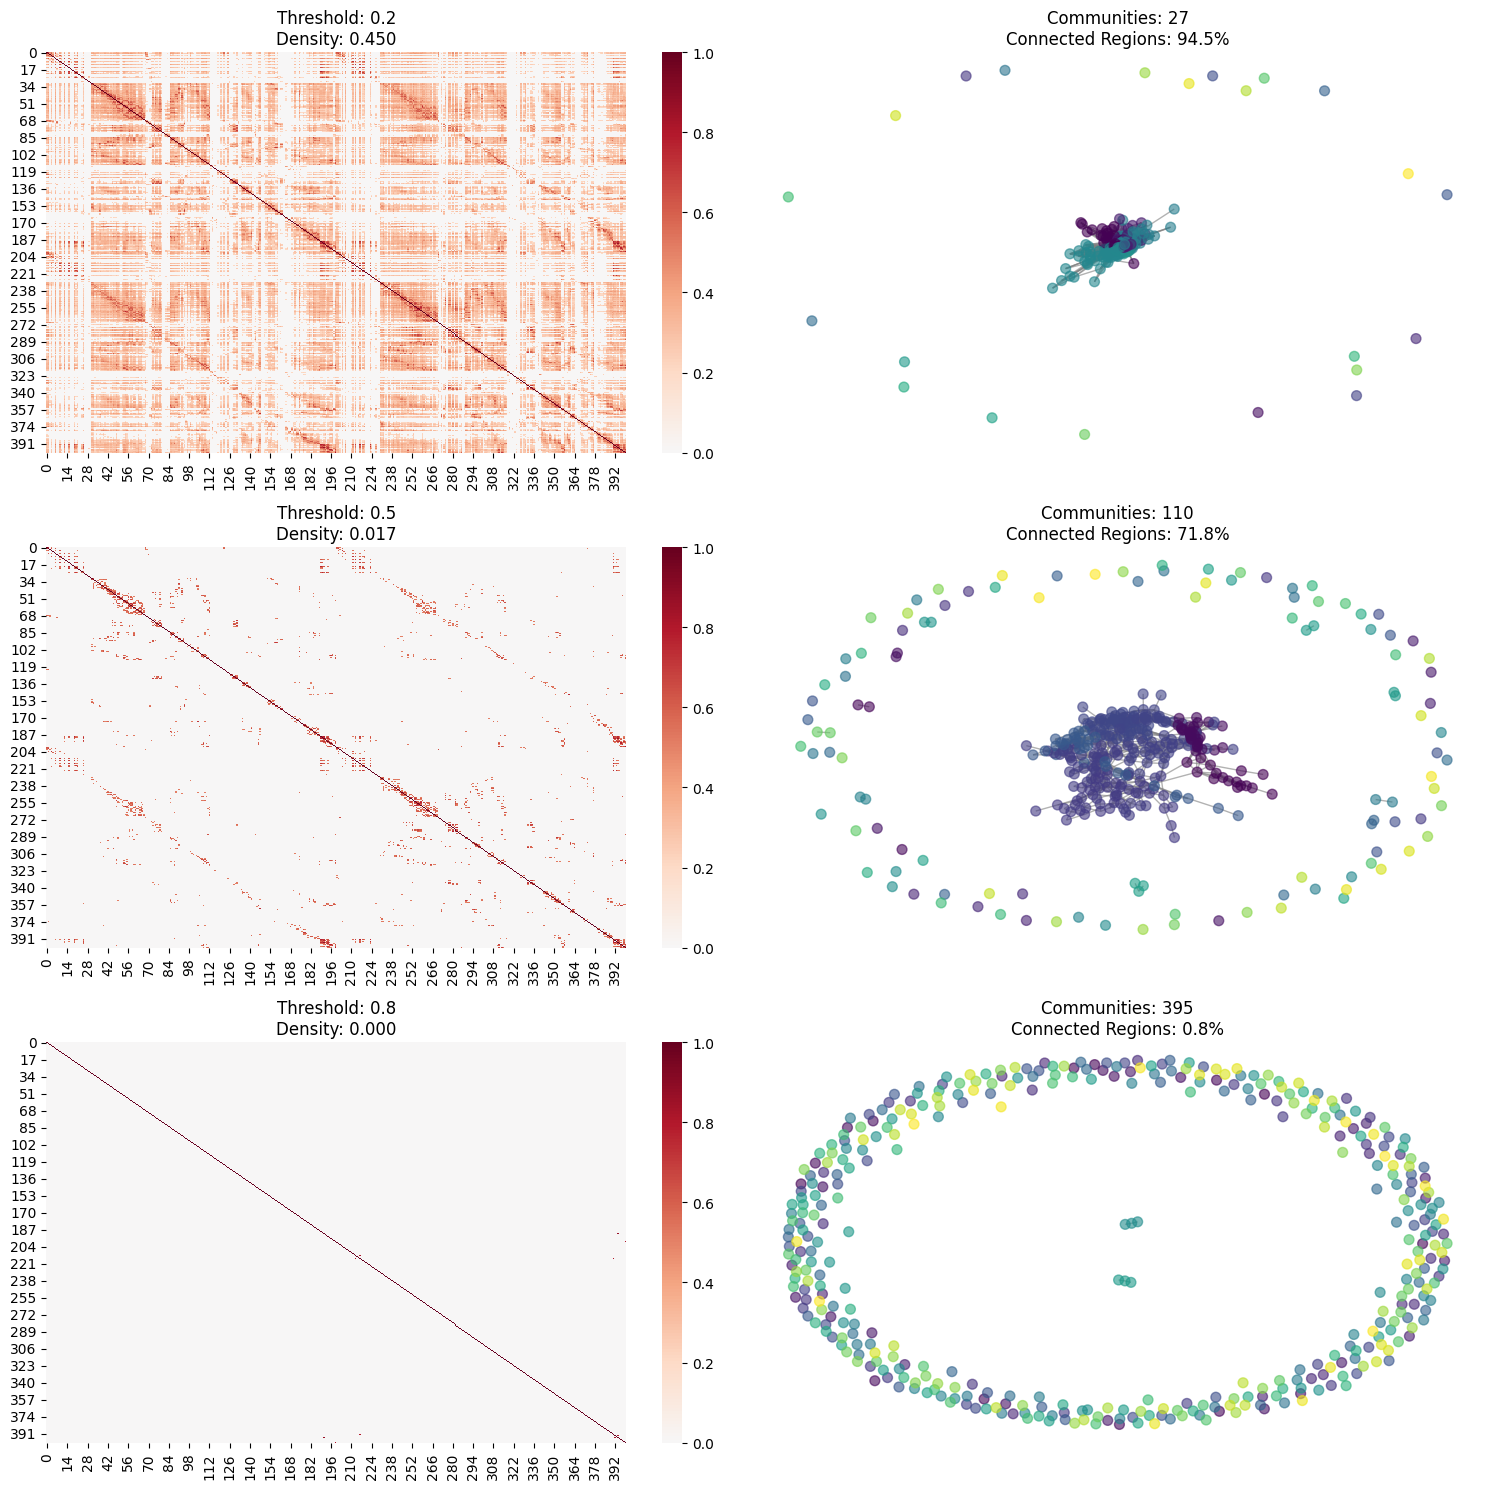


Summary of findings:
-------------------
Total brain regions analyzed: 400

What the thresholds tell us:

At threshold 0.2:
- Kept 45.5% of all possible connections
- Found 28 distinct brain communities
- 36096 strong connections between regions

At threshold 0.5:
- Kept 2.2% of all possible connections
- Found 113 distinct brain communities
- 1529 strong connections between regions

At threshold 0.8:
- Kept 0.5% of all possible connections
- Found 395 distinct brain communities
- 205 strong connections between regions


In [15]:
#strict tutorial 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import community
from nilearn import datasets

def analyze_brain_connectivity(matrix, labels, thresholds=[0.2, 0.5, 0.8]):
    """
    Analyze how different correlation thresholds affect brain network properties.
    
    Args:
        matrix: Correlation matrix of brain regions
        labels: Brain region labels
        thresholds: List of correlation thresholds to test
    """
    # Set up figure for our results
    fig, axes = plt.subplots(len(thresholds), 2, figsize=(15, 5*len(thresholds)))
    
    for idx, threshold in enumerate(thresholds):
        # Create thresholded matrix
        matrix_thresh = matrix.copy()
        matrix_thresh[matrix_thresh <= threshold] = 0
        
        # Create graph
        G = nx.from_numpy_array(matrix_thresh)
        G.remove_edges_from(list(nx.selfloop_edges(G)))
        
        # Calculate basic properties
        density = nx.density(G)
        communities = community.best_partition(G, weight='weight')
        n_communities = len(set(communities.values()))
        
        # Get largest connected group of brain regions
        largest_component = max(nx.connected_components(G), key=len)
        connectivity_ratio = len(largest_component) / G.number_of_nodes()
        
        # Plot correlation matrix
        sns.heatmap(matrix_thresh, ax=axes[idx, 0], cmap='RdBu_r', center=0)
        axes[idx, 0].set_title(f'Threshold: {threshold}\nDensity: {density:.3f}')
        
        # Plot network
        nx.draw(G, ax=axes[idx, 1], 
                node_color=list(communities.values()),
                node_size=50,
                edge_color='gray',
                alpha=0.6)
        axes[idx, 1].set_title(f'Communities: {n_communities}\nConnected Regions: {connectivity_ratio:.1%}')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nSummary of findings:")
    print("-------------------")
    print(f"Total brain regions analyzed: {len(labels)}")
    print("\nWhat the thresholds tell us:")
    for threshold in thresholds:
        matrix_thresh = matrix.copy()
        matrix_thresh[matrix_thresh <= threshold] = 0
        G = nx.from_numpy_array(matrix_thresh)
        density = nx.density(G)
        n_communities = len(set(community.best_partition(G, weight='weight').values()))
        print(f"\nAt threshold {threshold}:")
        print(f"- Kept {(density*100):.1f}% of all possible connections")
        print(f"- Found {n_communities} distinct brain communities")
        
        # Count strong connections
        strong_connections = np.sum(matrix_thresh > 0) / 2  # divide by 2 because matrix is symmetric
        print(f"- {strong_connections:.0f} strong connections between regions")

# Run the analysis
analyze_brain_connectivity(matrix, clean_labels)

In [16]:
def analyze_communities(matrix, labels, threshold=0.5):
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    
    # Create graph and find communities
    G = nx.from_numpy_array(matrix_thresh)
    communities = community.best_partition(G, weight='weight')
    
    # Group regions by community
    community_regions = {}
    for node, comm_id in communities.items():
        if comm_id not in community_regions:
            community_regions[comm_id] = []
        community_regions[comm_id].append(labels[node])
    
    # Print largest communities
    print("Largest brain networks found:")
    for comm_id, regions in sorted(community_regions.items(), 
                                 key=lambda x: len(x[1]), 
                                 reverse=True)[:5]:
        print(f"\nNetwork {comm_id} ({len(regions)} regions):")
        print(", ".join(regions[:5]) + "..." if len(regions) > 5 else "")

# Run analysis
analyze_communities(matrix, clean_labels)

Largest brain networks found:

Network 20 (47 regions):
SomMot_2, SomMot_4, SomMot_5, SomMot_6, SomMot_7...

Network 22 (47 regions):
SomMot_16, SomMot_17, SomMot_19, SomMot_20, SomMot_22...

Network 21 (34 regions):
SomMot_15, SomMot_21, Post_5, Post_6, Post_7...

Network 3 (33 regions):
Vis_7, Vis_10, Vis_11, Vis_13, Vis_16...

Network 23 (30 regions):
SomMot_18, SomMot_23, SomMot_24, Post_15, Med_1...


In [17]:
def analyze_network_composition(matrix, labels, threshold=0.5):
    # Create thresholded matrix and find communities
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    G = nx.from_numpy_array(matrix_thresh)
    communities = community.best_partition(G, weight='weight')
    
    # Analyze composition of each community
    community_composition = {}
    for node, comm_id in communities.items():
        if comm_id not in community_composition:
            community_composition[comm_id] = {}
        
        # Get the network type (before the underscore)
        network_type = labels[node].split('_')[0]
        community_composition[comm_id][network_type] = community_composition[comm_id].get(network_type, 0) + 1
    
    # Print composition of largest communities
    print("Detailed composition of largest networks:")
    for comm_id in [20, 22, 21, 3, 23]:  # Our largest networks
        print(f"\nNetwork {comm_id} composition:")
        total = sum(community_composition[comm_id].values())
        for network, count in sorted(community_composition[comm_id].items(), key=lambda x: x[1], reverse=True):
            percentage = (count/total) * 100
            print(f"{network}: {count} regions ({percentage:.1f}%)")

# Run the analysis
analyze_network_composition(matrix, clean_labels)

Detailed composition of largest networks:

Network 20 composition:
SomMot: 19 regions (38.0%)
FrOperIns: 9 regions (18.0%)
Par: 5 regions (10.0%)
TempOccPar: 4 regions (8.0%)
Temp: 4 regions (8.0%)
PFC: 3 regions (6.0%)
ParOper: 2 regions (4.0%)
PFCv: 2 regions (4.0%)
Post: 1 regions (2.0%)
TempOcc: 1 regions (2.0%)

Network 22 composition:
Med: 11 regions (35.5%)
pCunPCC: 8 regions (25.8%)
SomMot: 7 regions (22.6%)
Post: 2 regions (6.5%)
Cing: 2 regions (6.5%)
pCun: 1 regions (3.2%)

Network 21 composition:
SomMot: 14 regions (43.8%)
PFCl: 5 regions (15.6%)
FEF: 4 regions (12.5%)
PrCv: 3 regions (9.4%)
Post: 2 regions (6.2%)
ParOper: 2 regions (6.2%)
PFC: 1 regions (3.1%)
PrC: 1 regions (3.1%)

Network 3 composition:
Vis: 19 regions (57.6%)
pCunPCC: 12 regions (36.4%)
pCun: 2 regions (6.1%)

Network 23 composition:
SomMot: 30 regions (69.8%)
Med: 4 regions (9.3%)
Post: 3 regions (7.0%)
FEF: 3 regions (7.0%)
PFC: 1 regions (2.3%)
PFCl: 1 regions (2.3%)
PFCdPFCm: 1 regions (2.3%)


In [18]:
def visualize_community_structure(matrix, labels, threshold=0.5):
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    
    # Create graph and find communities
    G = nx.from_numpy_array(matrix_thresh)
    communities = community.best_partition(G, weight='weight')
    
    # Create a summary of each community's size and main type
    community_summary = {}
    for node, comm_id in communities.items():
        if comm_id not in community_summary:
            community_summary[comm_id] = {'size': 0, 'types': {}}
        
        community_summary[comm_id]['size'] += 1
        node_type = labels[node].split('_')[0]
        community_summary[comm_id]['types'][node_type] = community_summary[comm_id]['types'].get(node_type, 0) + 1
    
    # Print summary sorted by size
    print("Community Structure at Threshold 0.5:")
    print("------------------------------------")
    for comm_id, info in sorted(community_summary.items(), key=lambda x: x[1]['size'], reverse=True):
        main_type = max(info['types'].items(), key=lambda x: x[1])[0]
        print(f"\nCommunity {comm_id}: {info['size']} nodes")
        print(f"Dominant type: {main_type} ({info['types'][main_type]} nodes)")
        if len(info['types']) > 1:
            print("Also contains:", ', '.join([f"{k} ({v})" for k, v in info['types'].items() if k != main_type]))

# Run the visualization
visualize_community_structure(matrix, clean_labels)

Community Structure at Threshold 0.5:
------------------------------------

Community 19: 59 nodes
Dominant type: SomMot (23 nodes)
Also contains: Post (1), ParOper (2), TempOcc (1), FrOperIns (13), Temp (10), Par (4), PFC (2), TempOccPar (2), PFCv (1)

Community 20: 45 nodes
Dominant type: SomMot (15 nodes)
Also contains: Post (13), PrCv (2), ParOper (2), Par (9), TempOccPar (2), PrC (1), PFCl (1)

Community 22: 45 nodes
Dominant type: PFCl (20 nodes)
Also contains: SomMot (1), FEF (6), PrCv (1), PFCmp (2), PFC (9), Med (2), PFCdPFCm (4)

Community 1: 35 nodes
Dominant type: Vis (21 nodes)
Also contains: pCunPCC (12), pCun (2)

Community 23: 35 nodes
Dominant type: SomMot (28 nodes)
Also contains: Med (2), Post (4), FEF (1)

Community 21: 31 nodes
Dominant type: Med (11 nodes)
Also contains: SomMot (7), Post (2), pCun (1), Cing (2), pCunPCC (8)

Community 0: 14 nodes
Dominant type: Vis (6 nodes)
Also contains: Post (3), TempPole (5)

Community 61: 12 nodes
Dominant type: PFC (6 nodes)

In [ ]:
#topology and geometry analysis and visualization
